In [220]:
import torch
import clip
import numpy as np
import os
import random
from lucent.optvis.param.images import image
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo import util
from collections import OrderedDict
from tqdm.auto import tqdm
from PIL import Image

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [259]:
model, transforms = clip.load("RN50", device=device)

In [260]:
model = model.visual

In [15]:
param_f = lambda: param.image(224)
opt = lambda params: torch.optim.Adam(params, 5e-2)
obj = "layer4_2_conv3:512"

100%|██████████| 512/512 [00:18<00:00, 27.48it/s]



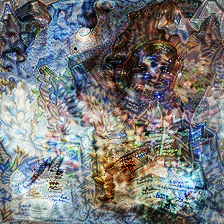

In [16]:
_ = render.render_vis(model, obj, param_f, show_inline=True)

In [17]:
linear_probe_model = torch.load('model_checkpoint.pth')

In [213]:
def tensor_to_img_array(tensor):
    image = tensor.cpu().detach().numpy()
    image = np.transpose(image, [0, 2, 3, 1])
    return image

In [40]:
model

ModifiedResNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), str

In [45]:
model._modules['layer2']._modules.keys()

odict_keys(['0', '1', '2', '3'])

In [333]:
class Hook:
    
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.capture_features)
        self.backward_hook = module.register_full_backward_hook(self.capture_gradients)
    def capture_features(self, module, input, output):
        self.module = module
        self.input = input
        self.features = output
        
    def capture_gradients(self, module, grad_input, grad_output):
        self.grad_input = grad_input

In [373]:
def register_hooks(model):
    features = OrderedDict()
    def traverse(module, prefix=[]):
        if hasattr(module, "_modules"):
            for name, sub_module in module._modules.items():
                if sub_module is not None:
                    hook_name = "_".join(prefix + [name])
                    features[hook_name] = Hook(sub_module)
                    traverse(sub_module, prefix = prefix + [name])
                if isinstance(sub_module, torch.nn.ReLU):
                    sub_module.inplace = False
    traverse(model)
    
    def hook(layer):
        hook_obj = features[layer]
        return hook_obj.features, hook_obj.grad_input
    return hook

In [374]:
features = register_hooks(model)

In [375]:
layer_linear_probe = "layer1_2_relu3"
layer_visualization = "layer4_2_conv3"

In [377]:
color_correlation_svd_sqrt = np.asarray([[0.26, 0.09, 0.02],
                                         [0.27, 0.00, -0.05],
                                         [0.27, -0.09, 0.03]]).astype("float32")

max_norm_svd_sqrt = np.max(np.linalg.norm(color_correlation_svd_sqrt, axis=0))

color_correlation_normalized = color_correlation_svd_sqrt / max_norm_svd_sqrt

In [378]:
def _linear_decorrelate_color(tensor):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    t_permute = tensor.permute(0, 2, 3, 1)
    t_permute = torch.matmul(t_permute, torch.tensor(color_correlation_normalized.T).to(device))
    tensor = t_permute.permute(0, 3, 1, 2)
    return tensor


def to_valid_rgb(image_f, decorrelate=False):
    def inner():
        image = image_f()
        if decorrelate:
            image = _linear_decorrelate_color(image)
        return torch.sigmoid(image)
    return inner

In [379]:
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""
    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)

In [380]:
def fft_image(shape, sd=None, decay_power=1):
    batch, channels, h, w = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (batch, channels) + freqs.shape + (2,) # 2 for imaginary and real components
    sd = sd or 0.01

    spectrum_real_imag_t = (torch.randn(*init_val_size) * sd).to(device).requires_grad_(True)

    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale = torch.tensor(scale).float()[None, None, ..., None].to(device)

    def inner():
        scaled_spectrum_t = scale * spectrum_real_imag_t
        if True:
            import torch.fft
            if type(scaled_spectrum_t) is not torch.complex64:
                scaled_spectrum_t = torch.view_as_complex(scaled_spectrum_t)
            image = torch.fft.irfftn(scaled_spectrum_t, s=(h, w), norm='ortho')
        else:
            import torch
            image = torch.irfft(scaled_spectrum_t, 2, normalized=True, signal_sizes=(h, w))
        image = image[:batch, :channels, :h, :w]
        magic = 4.0 # Magic constant from Lucid library; increasing this seems to reduce saturation
        image = image / magic
        return image
    return [spectrum_real_imag_t], inner

In [381]:
def generate_img(w, h=None, sd=None, batch=None, decorrelate=True,
          fft=True, channels=None):
    h = h or w
    batch = batch or 1
    ch = channels or 3
    shape = [batch, ch, h, w]
    param_f = fft_image if fft else pixel_image
    params, image_f = param_f(shape, sd=sd)
    if channels:
        output = to_valid_rgb(image_f, decorrelate=False)
    else:
        output = to_valid_rgb(image_f, decorrelate=decorrelate)
    return params, output

In [382]:
def render_visualization(image_function, model, channel):
    n=1000
    batch_bar = tqdm(total=n, dynamic_ncols=True, leave=False, position=0, desc='Train')

    for j in range(n):
        def closure():
            optimizer.zero_grad()
            model.forward(image_function())

            f_x = features(layer_visualization)[0]
            g_x = features(layer_linear_probe)[0]
            print(features(layer_visualization)[1].shape)
            loss = -f_x[0, channel, :, :].mean() + torch.dot(g_x[0].flatten().type(torch.FloatTensor).to(device), linear_probe_model['weight'][0].to(device))

            loss.backward()
            batch_bar.set_postfix(
                loss="{:.04f}".format(float(loss)))
            return loss
        
        optimizer.step(closure)

        batch_bar.update()

In [383]:
params,image_f = generate_img(224)
optimizer = torch.optim.Adam(params, lr=5e-2)
render_visualization(image_f, model, 512)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

In [319]:
def show_image(tensor):
    image = tensor_to_img_array(tensor)
    assert len(image.shape) in [
        3,
        4,
    ], "Image should have 3 or 4 dimensions, invalid image shape {}".format(image.shape)
    # Change dtype for PIL.Image
    image = (image * 255).astype(np.uint8)
    if len(image.shape) == 4:
        image = np.concatenate(image, axis=1)
    display(Image.fromarray(image))

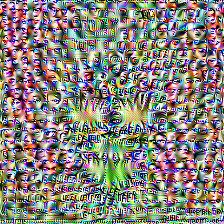

In [320]:
%matplotlib inline
show_image(image_f())